In [2]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.metrics import r2_score 
import time
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

### Save Trimmed Data to new CSV file

In [3]:
seed = 4

# Shortcut to read trimmed dataset
df = pd.read_csv('data/hsls_17_students_clean.csv')

# Format categorical variables in df
cat_type = ['X1SEX', 'X1RACE', 'X1STU30OCC_STEM1', 'X2STU30OCC_STEM1', 'X1CONTROL', 'X2CONTROL', 'X3CONTROL', 
            'X1LOCALE', 'X2LOCALE', 'X3LOCALE', 'X1REGION', 'X2REGION', 'X3REGION', 'X2ENROLSTAT',  'X2DROPSTAT', 'X2EVERDROP', 
            'X3DROPOUTTIME', 'X3DROPSTAT', 'X3EVERDROP', 'X3PROGLEVEL', 'X3CLGANDWORK', 'X3EVERGED', 'X3HSCOMPSTAT', 'X4HSCOMPSTAT',
           'X3ELLSTATUS','X4HSCOMPSTAT','X4EVRTRANSHS_R','X4EVRAPPCLG','X4PS1SELECT','X4REFDEGTYPE','X4PSENRSTLV',
            'X4RFDGCOMP','X4INCOMECAT','X4HSCLGCRED','X4REFSECTOR',
            'X4PS1DEGTYPE1','X4PSLFSTFB16','X4OCCFB2','X5LASTENR16','X5STEMCRED','X5PS1SEC',
            'X4EVERGED','X4EVR2YPUB','X4REFLEVEL','X4FB16ENRSTAT','X4RFDGMJSTEM','X4OCCFBSTEM1',
            'X5CTECRED','X4GEDPASSED','X4ATNDCLG16FB','X4PS1SECTOR','X4REFSELECT','X4ATPRLVLA','X4RFDGMJ123',
            'X4OCC30RELATE','X5PS1SLC','X4SQSTAT','X4EVERDROP','X4PS1LEVEL','X4ATNDCLG16FB','X4PS1LEVEL','X4REFDEGTYPE','X4PSENRSTLV','X4RFDGCOMP','X4INCOMECAT',
            'X4PS1SELECT','X4PS1DEGTYPE1','X4PSLFSTFB16','X4OCCFB2','X5LASTENR16','X5STEMCRED','X4EVERDROP','X4EVRAPPCLG','X4REFSECTOR',
            'X4FB16ENRSTAT','X4OCCFBSTEM1','X5CTECRED','X4EVRTRANSHS_R','X4REFLEVEL','X4ATPRLVLA','X4OCC30RELATE',
            'X5PS1SLC','X4HSCLGCRED','X4EVR2YPUB','X4PS1SECTOR','X4REFSELECT','X5PS1SEC','X5PFYSEC','X4ATNDCLG16FB',
            'X4PS1LEVEL','X4REFDEGTYPE','X4PSENRSTLV','X4RFDGCOMP','X4GEDPASSED','X4PS1SELECT','X4PS1DEGTYPE1','X4OCCFB2','X5STEMCRED','X4REFSECTOR',
            'X4OCCFBSTEM1','X5CTECRED','X4REFLEVEL','X4ATPRLVLA','X4OCC30RELATE','X4PS1SECTOR','X4REFSELECT',
            'X5LASTENR16','X5STEMCRED','X5CTECRED','X5PS1SLC','X5PS1SEC', 'X5SRRESP', 'X5PFYSLC', 'X5PFYDEGREE', 'X5PFYDEGREE', 'S1FAVSUBJ', 'S2GRD1112',
           'S2PASSGRADE', 'S2EDUEXP', 'S2CLG2013', 'S2FOCUS2013', 'S2CLGFT2013', 'S2AFFOCCTRN', 'S2AFF2YPUB', 'S2AFF4YIN', 'S2AFF4YOUT', 'S2AFF4YPRV', 'S2AFF4YSEL',
           'S2NEVERCLG', 'S2CANTAFFORD', 'S2MUSIC', 'S2ART', 'S2DRAMA', 'S2SPORTS', 'S2CLUB', 'S2ACADEMIC', 'S3HSCRED', 'S3FOCUS', 'S3CLGFT', 'S3WORKFT', 
            'S2SUREDIPL', 'S2INSCHSUSP', 'S1S8', 'S1HRWORK', 'S1WEBINFO', 'S1SUREHSGRAD', 'S1SCHWASTE', 'X1HHNUMBER',
           'X2HHNUMBER', 'X1PAREDEXPCT', 'X2PAREDEXPCT', 'X2STUEDEXPCT', 'X1STUEDEXPCT', 'S1M8', 'S1SAFE', 'S2SATNUM',
           'S1HRACTIVITY', 'S2ARRESTED', 'S1GOODGRADES', 'S1M8GRADE', 'S1S8GRADE', 'X2NUMHS', 'S2SCHWASTE']
for c in cat_type:
    df[c] = df[c].astype('category')

In [4]:
# Count number of X1 and S1 columns left in dataset
X_cols = []        # X1 and S1 columns
X1S1 = {'X1','S1'}

col_list = df.columns.tolist()
for i in col_list:
    if i[:2] in X1S1:
        X_cols.append(i)
print('X1 and S1 Vars:', len(X_cols))

X1 and S1 Vars: 30


In [5]:
# Get lists of categorical and continuous variables, so we can standardize only continuous variables 
# and encode only categorical variables
cat_vars = []            # List of Categorical Predictors
cont_vars = []           # List of Continuous Predictors

for i in X_cols:
    if df[i].dtype=='category':
        cat_vars.append(i)
    else:
        cont_vars.append(i)

# Standardized Math Theta Score Prediction

### Define Train and Test Sets and Feature Selection

In [6]:
#some of these categorical variables regquire ordinal encoding rather than using them as dummies for each group
cat_ord_type = ['S1HRWORK', 'S1WEBINFO', 'S1SCHWASTE', 'X1PAREDEXPCT', 'X1STUEDEXPCT', 'X1HHNUMBER', 
                'S1SAFE', 'S1HRACTIVITY', 'S1GOODGRADES', 'S1M8GRADE', 'S1S8GRADE']

cat_vars = list(set(cat_vars) - set(cat_ord_type))

In [7]:
# Split DataFrame into X and y (Standardized Math Theta Score)
X = df[X_cols]
y_score = df['X2TXMTSCOR']

# Convert categorical variables using pd.get_dummies
X_dummy = pd.get_dummies(data=X[cat_vars], drop_first=False)
X = pd.concat([X,X_dummy], axis=1).drop(columns=cat_vars)

# Deal with ordinal categorical variables
encoder = OrdinalEncoder()
encoder.fit_transform(X[cat_ord_type])

# Get length of continuous features
print("Number of Continuous Features:", len(cont_vars))

# Get Number of Categorical Features (Dummy Variables)
print("Number of Categorical Features (Dummy Variables):", len(X.columns)-len(cont_vars))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_score, test_size = 0.25, random_state = seed)

# Standardize continuous variables
scaler = RobustScaler()
X_train[cont_vars] = scaler.fit_transform(X_train[cont_vars])
X_test[cont_vars] = scaler.fit_transform(X_test[cont_vars])

Number of Continuous Features: 9
Number of Categorical Features (Dummy Variables): 79


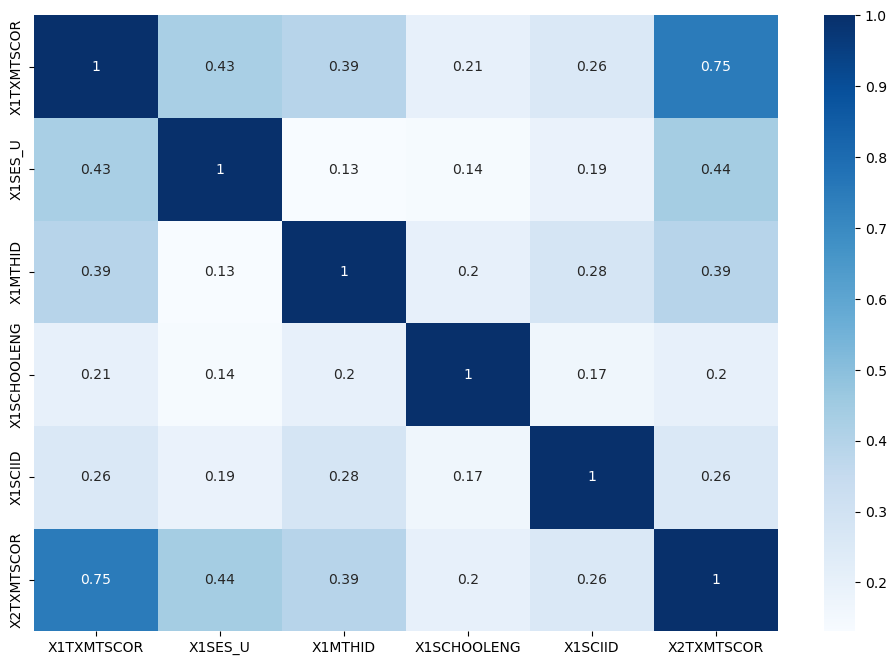

In [9]:
# Heatmap for Correlation
school_corr = df[['X1TXMTSCOR', 'X1SES_U', 'X1MTHID', 'X1SCHOOLENG', 'X1PAREDEXPCT', 'X1SCIID',
                  'S1M8', 'S1HRWORK', 'S1HRACTIVITY', 'S1GOODGRADES','X2TXMTSCOR']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(school_corr, cmap="Blues", annot=True)

# Save Plot
plt.savefig('MTH_Score_Heatmap.png', bbox_inches='tight')

### Feature Selection

In [10]:
# Linear Regression with 'for' Loop Feature Selection

lm = LinearRegression()
lm.fit(X_train, y_train)
print("Train R-squared:", lm.score(X_train, y_train))
print("Test R-squared:", lm.score(X_test, y_test))

cross_val = KFold(n_splits=10, random_state=None, shuffle=False)
lin_CV_scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=cross_val)
all_vars_cv = np.mean(np.abs(lin_CV_scores))
print("CV Error:", all_vars_cv, '\n')

# Creating lists of number of features and of CV scores, for graphing based on number of predictors
n_features = [10,15,20,25,30,33,34,35,36,37,40,45,50]
cv_scores = []

# Run Sequential Feature Selection
start = time.time()

for i in n_features:
    sfs = SequentialFeatureSelector(lm, n_features_to_select = i, direction='forward', 
                                scoring='neg_mean_squared_error', cv=10)
    sfs.fit(X_train, y_train)
    X_train_sel = sfs.transform(X_train)
    X_test_sel = sfs.transform(X_test)
    lm_sel = LinearRegression()
    lm_sel.fit(X_train_sel, y_train)
    lin_CV_scores = cross_val_score(lm_sel, X_train_sel, y_train, scoring='neg_mean_squared_error', cv=cross_val)
    cv_error = np.mean(np.abs(lin_CV_scores))
    cv_scores.append(cv_error)
    print(i, "Features:")
    print("     Train R-squared =", lm_sel.score(X_train_sel, y_train))
    print("     Test R-squared =", lm_sel.score(X_test_sel, y_test))
    print("            CV Error =", cv_error)
    
n_features.append(len(X_train.columns))
cv_scores.append(all_vars_cv)
computation_time = (time.time()-start)
print('\nTime:', computation_time, 'seconds')

Train R-squared: 0.625583071050174
Test R-squared: 0.6191828300524698
CV Error: 39.21776467199419 

10 Features:
     Train R-squared = 0.6161303493598055
     Test R-squared = 0.6130636382275367
            CV Error = 39.68543657193446
15 Features:
     Train R-squared = 0.6202989806573564
     Test R-squared = 0.6157801181930762
            CV Error = 39.281264464375695
20 Features:
     Train R-squared = 0.6223383369188461
     Test R-squared = 0.6147530234087651
            CV Error = 39.107445976025
25 Features:
     Train R-squared = 0.6235496560681077
     Test R-squared = 0.6147914522307965
            CV Error = 39.023452352354745
30 Features:
     Train R-squared = 0.6240885886830794
     Test R-squared = 0.6153610198117024
            CV Error = 38.98677836626018
33 Features:
     Train R-squared = 0.6242876071230005
     Test R-squared = 0.6151188603119646
            CV Error = 38.978455759442404
34 Features:
     Train R-squared = 0.624340842161682
     Test R-squared = 0

# The number of features with the lowest CV Error is 40

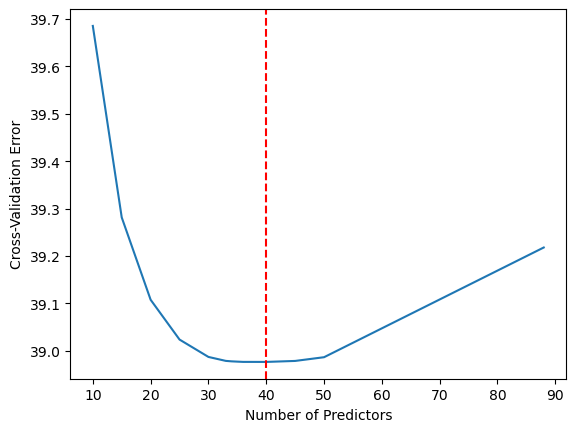

<Figure size 640x480 with 0 Axes>

In [17]:
# Plot CV Error vs Number of Predictors to get best number of predictors to use
plt.plot(n_features, cv_scores)
plt.xlabel('Number of Predictors')
plt.ylabel('Cross-Validation Error')
plt.axvline(x=40, color='r', linestyle='--')
plt.show()

# Save Plot
plt.savefig('N_Predictors_vs_CVError_MTH_score.png')

### Linear Regression

In [12]:
# Test Linear Regression with 40 selected
lm = LinearRegression()
lm.fit(X_train, y_train)
sfs = SequentialFeatureSelector(lm, n_features_to_select = 40, direction='forward', 
                                scoring='neg_mean_squared_error', cv=10)
sfs.fit(X_train, y_train)

# Save train and test X dataframes with selected features
X_train_sel = sfs.transform(X_train)
X_test_sel = sfs.transform(X_test)

# Test and report results of selected features
lm = LinearRegression()
lm.fit(X_train_sel, y_train)

# Scoring Model
lin_R2_train = lm.score(X_train_sel, y_train)
lin_R2_test = lm.score(X_test_sel, y_test)
lin_CV_error = np.mean(np.abs(cross_val_score(lm, X_train_sel, y_train, 
                                              scoring='neg_mean_squared_error', cv=cross_val)))
y_pred_lm = lm.predict(X_test_sel)
lin_mse = mean_squared_error(y_test, y_pred_lm)

# Print Model Scores
print("Linear Regression Train R-squared:", lin_R2_train)
print("Linear Regression Test R-squared:", lin_R2_test)
print("Linear Regression CV Error:", lin_CV_error)
print("Linear Regression MSE:", lin_mse)

feature_names = np.array(X_train.columns)
vars_tokeep = feature_names[sfs.get_support()]

Linear Regression Train R-squared: 0.6246036569072106
Linear Regression Test R-squared: 0.6161123136738489
Linear Regression CV Error: 38.976264985520935
Linear Regression MSE: 39.4579185135697


### Ridge Regression

In [13]:
# The CV version of Ridge is used because it already performs cross validation and gets the best alpha value exactly.

# Fit Model
ridge_cv = RidgeCV(scoring='r2').fit(X_train_sel, y_train)

# Get CV_error
print('Ridge Model Results')
ridge_CV_error = -np.mean(cross_val_score(ridge_cv, X_train_sel, y_train, scoring='neg_mean_squared_error', cv=cross_val))
print("Ridge CV Error:", ridge_CV_error)

# Model Score and Best Alpha
ridge_R2_train = np.abs(ridge_cv.best_score_)
print("Best Score (Train R_squared):", ridge_R2_train)
print("Best Alpha:", ridge_cv.alpha_)

# Test Ridge Model
y_pred_ridge = ridge_cv.predict(X_test_sel)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print("Ridge MSE:", ridge_mse)

Ridge Model Results
Ridge CV Error: 38.972908493305134
Best Score (Train R_squared): 0.6223674822226
Best Alpha: 10.0
Ridge MSE: 39.456244285321404


### Lasso Regression

In [15]:
lassoCV = LassoCV(cv=10).fit(X_train, y_train)
cross_val = KFold(n_splits=10, random_state=None, shuffle=False)

# Score model
lasso_R2_train = np.abs(lassoCV.score(X_train, y_train))
lasso_CV_error = -np.mean(cross_val_score(lassoCV, X_train, y_train, scoring='neg_mean_squared_error', cv=cross_val))
y_pred_lasso = lassoCV.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)

# Print model scores
print("Lasso - R-squared:", lasso_R2_train)
print("Lasso CV Error:", lasso_CV_error)
print("Lasso MSE:", lasso_mse)

Lasso - R-squared: 0.6236221524153964
Lasso CV Error: 39.16911241516626
Lasso MSE: 39.3895325399968


### Random Forest Regression

In [19]:
# Random Forest Tuning using GridSearchCV
tuned_parameters = {'n_estimators': [50, 100, 200, 300], 
                    'max_features': ('sqrt','log2')}
rfr_tuned = GridSearchCV(RandomForestRegressor(random_state=1), tuned_parameters, cv=10,n_jobs=-1, verbose=1)
rfr_tuned.fit(X_train, y_train)

# Score model
cv_scores = cross_val_score(rfr_tuned, X_train_sel, y_train, cv=10, 
                            scoring='neg_mean_squared_error')
rf_CV_error = np.mean(abs(cv_scores))
rf_R2_train = rfr_tuned.score(X_train, y_train)
rf_R2_test = rfr_tuned.score(X_test, y_test)
y_pred_rfr = rfr_tuned.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rfr)

# Report model scores
print("------ Best Parameters  ----------")
print(rfr_tuned.best_params_)
print("------ Best Model Train R^2  ----------")
print(rf_R2_train)
print("------ Best Model Test R^2 ----------")
print(rf_R2_test)
print("-------- Best Model MSE -----------")
print(rf_mse)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
------ Best Parameters  ----------
{'max_features': 'sqrt', 'n_estimators': 300}
------ Best Model Train R^2  ----------
0.9474797968893285
------ Best Model Test R^2 ----------
0.6152673401510271
-------- Best Model MSE -----------
39.54476916702177


In [20]:
rf = RandomForestRegressor(n_estimators=300, max_features='sqrt', random_state=seed)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_R2_train = cross_val_score(rf, X_train, y_train, cv=10, scoring='r2').mean()
rf_R2_test = rf.score(X_test, y_test)
rf_mse = mean_squared_error(y_test, rf_pred)

print("Train R^2:", rf_R2_train)
cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rf_CV_error = np.mean(abs(cv_scores))
print("Train CV Error (MSE):", rf_CV_error)
print("Test R^2:", rf_R2_test)

print("Test MSE:", rf_mse)

Train R^2: 0.6154591134094551
Train CV Error (MSE): 39.62243809047406
Test R^2: 0.6149875660045996
Test MSE: 39.573525769187334


In [21]:
# Create a dataframe of metrics for each model to compare
pred_model_results = pd.DataFrame({'CV Error': [lin_CV_error, ridge_CV_error, lasso_CV_error, rf_CV_error], 
                                   'R_squared': [lin_R2_train, ridge_R2_train, lasso_R2_train, rf_R2_train],
                                  'MSE': [lin_mse, ridge_mse, lasso_mse, rf_mse]}, 
                                  index = ['Linear', 'Ridge', 'Lasso', 'Random Forest'])
pred_model_results

,CV Error,R_squared,MSE
Linear,38.976265,0.624604,39.457919
Ridge,38.972908,0.622367,39.456244
Lasso,39.169112,0.623622,39.389533
Random Forest,39.622438,0.615459,39.573526


# The best prediction model is the Linear Regression Model, with the lowest CV Error and the highest R_squared value

In [22]:
vars_tokeep

array(['X1STDOB', 'X1TXMTSCOR', 'X1HHNUMBER', 'X1SES_U', 'X1MTHID',
       'X1SCIID', 'X1SCHOOLENG', 'X1STUEDEXPCT', 'X1PAREDEXPCT',
       'S1M8GRADE', 'S1HRWORK', 'X1SEX_1', 'X1SEX_2', 'S1SUREHSGRAD_1',
       'S1SUREHSGRAD_4', 'X1LOCALE_2', 'X1LOCALE_3', 'X1REGION_3',
       'X1REGION_4', 'X1RACE_2', 'X1RACE_3', 'X1RACE_7', 'S1M8_-8',
       'S1M8_2', 'S1M8_4', 'S1M8_5', 'S1M8_6', 'X1CONTROL_1',
       'X1CONTROL_2', 'S1S8_-6', 'S1S8_2', 'S1S8_9', 'S1FAVSUBJ_-8',
       'S1FAVSUBJ_1', 'S1FAVSUBJ_5', 'S1FAVSUBJ_7', 'S1FAVSUBJ_12',
       'X1STU30OCC_STEM1_-8', 'X1STU30OCC_STEM1_1', 'X1STU30OCC_STEM1_5'],
      dtype=object)

C:\Users\mattw\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  del sys.path[0]
C:\Users\mattw\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  


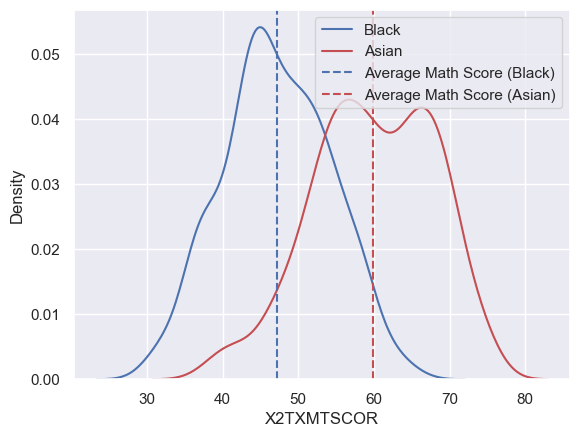

<Figure size 640x480 with 0 Axes>

In [49]:
# Distribution Plot 
sns.set(style="darkgrid")
y_pred_lm = pd.DataFrame(y_pred_lm, columns=['X2TXMTSCOR'])
X_test_sel = pd.DataFrame(X_test_sel, columns=vars_tokeep)
dist_df = pd.concat([y_pred_lm,X_test_sel], axis=1)

# Generate GPA lists by race
math_black = dist_df[dist_df['X1RACE_3']==1]['X2TXMTSCOR']
math_asian = dist_df[dist_df['X1RACE_2']==1]['X2TXMTSCOR']


# plotting both distibutions on the same figure
fig = sns.kdeplot(math_black, shade=False, color="b", label='Black')
fig = sns.kdeplot(math_asian, shade=False, color="r", label='Asian')

# Add lines to show mean GPA for both races
plt.axvline(x=math_black.mean(), color='b', linestyle='--', label = 'Average Math Score (Black)')
plt.axvline(x=math_asian.mean(), color='r', linestyle='--', label = 'Average Math Score (Asian)')

plt.legend()
plt.xlabel('X2TXMTSCOR')
plt.show()

# Save Plot
plt.savefig('Math_DIST_PLOT.png', bbox_inches='tight')